# Idea to improve motion network accuracy

Essentially I've done two things I've used a simple CIFAR style network (i.e. small convolution network of the internet that scores over 90% on CIFAR) which gave me 25% accuracy. Then I attempted using VGG16 which is quite a powerful network but I fudged the input layer weights using a trick call network modality. 
In theory this mean fine scale structures are potentially going into further on layers looking like garbage. I still got some decent results. But the training was quite slow. 

I do feel perhaps I'm not being patient with the training. 10 classes is one thing (CIFAR), a 101 is another. And then 1000 classes is definitely something else. Learning more fine grained differences may simply take quite a long time of learnning. I'm considering a much longer amount of training to see how it evolves. 

In [1]:
import os
import sys


up1 = os.path.abspath('../utils/') 
up2 = os.path.abspath('../models/') 
sys.path.insert(0, up1)
sys.path.insert(0, up2)

In [2]:
from optical_flow_data_gen import DataGenerator
from ucf101_data_utils import get_test_data_opt_flow, get_train_data_opt_flow
from motion_network import getKerasCifarMotionModel2, getKerasCifarMotionModelOnly
from keras.optimizers import SGD
from matplotlib import pyplot as plt
from keras.optimizers import SGD
import cv2 
import numpy as np



/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [3]:
from keras.callbacks import ModelCheckpoint, Callback

def get_callbacks(filepath):
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [msave]
file_path = "/data/su_buildup/two_stream_part2/data/weights/motion_model_weights_inv2_data_aug.hdf5"
callbacks = get_callbacks(filepath=file_path)

In [4]:
motion_model=getKerasCifarMotionModel2((224,224,2), 101, dropout=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      608       
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 224, 224, 32)      0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 32)      0         
__________

In [5]:

training_options = { 'rescale' : 1./255, 
                            'shear_range' : 0.2, 
                            'zoom_range' : 0.2, 
                            'horizontal_flip' : True,
                             'rotation_range':20,
                             'width_shift_range':0.2,
                             'height_shift_range':0.2,
                             'shear_range':0.2}

validation_options = { 'rescale' : 1./255 }




params_train = { 'data_dir' : "/data/tvl1_flow",
          'dim': (224,224),
          'batch_size': 32,
          'n_frames': 1,
          'n_frequency': 1,
          'shuffle': True, 
           'validation' : False,
               'training_opts' : training_options }

params_valid = { 'data_dir' : "/data/tvl1_flow",
          'dim': (224,224),
          'batch_size': 32,
          'n_frames': 1,
          'n_frequency': 1,
          'shuffle': True, 
           'validation' : True,
               'validation_opts' : validation_options}

In [6]:
id_labels_train = get_train_data_opt_flow('../data/ucf101_splits/trainlist01.txt')
labels = id_labels_train[1]
id_test = get_test_data_opt_flow('../data/ucf101_splits/testlist01.txt', \
                       '../data/ucf101_splits/classInd.txt')

training_generator = DataGenerator(*id_labels_train, **params_train)


validation_generator = DataGenerator(id_test[0], id_test[1], **params_valid)

In [7]:
mypotim = SGD(lr=1e-3, momentum=0.9)
motion_model.compile(loss='categorical_crossentropy',
              optimizer=mypotim,
              metrics=['accuracy'])

In [8]:
mod1 = motion_model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=4, epochs=2,
                    verbose=1)

Epoch 1/2
298/298 [==============================] - 131s 440ms/step - loss: 4.7024 - acc: 0.0365 - val_loss: 4.9782 - val_acc: 0.0387
Epoch 2/2
298/298 [==============================] - 127s 426ms/step - loss: 4.3208 - acc: 0.0622 - val_loss: 5.1799 - val_acc: 0.0519


    Its pretty clear cut that the excessive dropout  used by the motion_model_dropout causes a much slower learning rate. And  
    In theory one can expect that this model in the long term may converge with a higher accuracy. But can you wait  that long and is it worth it? Will you run out of money for the quicker model (with little or no dropout)

# Train for a long time 

In [9]:
mod1 = motion_model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=4, epochs=20,
                    verbose=1, callbacks=callbacks)

Epoch 1/20
298/298 [==============================] - 127s 427ms/step - loss: 4.1317 - acc: 0.0906 - val_loss: 4.9662 - val_acc: 0.0575
Epoch 2/20
298/298 [==============================] - 128s 429ms/step - loss: 3.9409 - acc: 0.1207 - val_loss: 4.7903 - val_acc: 0.0792
Epoch 3/20
298/298 [==============================] - 127s 428ms/step - loss: 3.8055 - acc: 0.1419 - val_loss: 4.8007 - val_acc: 0.0797
Epoch 4/20
298/298 [==============================] - 128s 428ms/step - loss: 3.6686 - acc: 0.1660 - val_loss: 4.4453 - val_acc: 0.0900
Epoch 5/20
298/298 [==============================] - 128s 428ms/step - loss: 3.5174 - acc: 0.1909 - val_loss: 4.5883 - val_acc: 0.1057
Epoch 6/20
298/298 [==============================] - 128s 428ms/step - loss: 3.3881 - acc: 0.2165 - val_loss: 4.4053 - val_acc: 0.1186
Epoch 7/20
298/298 [==============================] - 128s 428ms/step - loss: 3.2076 - acc: 0.2588 - val_loss: 4.7911 - val_acc: 0.1149
Epoch 9/20
298/298 [============================

In [10]:
mod1 = motion_model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=4, epochs=20,
                    verbose=1, callbacks=callbacks)

Epoch 1/20
298/298 [==============================] - 128s 431ms/step - loss: 2.2977 - acc: 0.4487 - val_loss: 4.2723 - val_acc: 0.1822
Epoch 2/20
298/298 [==============================] - 128s 429ms/step - loss: 2.2851 - acc: 0.4518 - val_loss: 4.1917 - val_acc: 0.1798
Epoch 3/20
298/298 [==============================] - 128s 429ms/step - loss: 2.2193 - acc: 0.4576 - val_loss: 4.4324 - val_acc: 0.1801
Epoch 4/20
298/298 [==============================] - 128s 429ms/step - loss: 2.1813 - acc: 0.4742 - val_loss: 4.2086 - val_acc: 0.1931
Epoch 5/20
298/298 [==============================] - 127s 428ms/step - loss: 2.1551 - acc: 0.4724 - val_loss: 4.2695 - val_acc: 0.1947
Epoch 6/20
298/298 [==============================] - 128s 428ms/step - loss: 2.0713 - acc: 0.4906 - val_loss: 4.3254 - val_acc: 0.1801
Epoch 7/20
298/298 [==============================] - 128s 429ms/step - loss: 2.0371 - acc: 0.5027 - val_loss: 4.4223 - val_acc: 0.1962
Epoch 8/20
298/298 [============================

In [12]:
mod1 = motion_model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=4, epochs=20,
                    verbose=1, callbacks=callbacks)

Epoch 1/20
298/298 [==============================] - 127s 427ms/step - loss: 1.5534 - acc: 0.6169 - val_loss: 4.4499 - val_acc: 0.2097
Epoch 2/20
298/298 [==============================] - 128s 429ms/step - loss: 1.5191 - acc: 0.6251 - val_loss: 4.3403 - val_acc: 0.2193
Epoch 3/20
298/298 [==============================] - 128s 429ms/step - loss: 1.4688 - acc: 0.6358 - val_loss: 4.2652 - val_acc: 0.2415
Epoch 4/20
298/298 [==============================] - 128s 429ms/step - loss: 1.4501 - acc: 0.6381 - val_loss: 4.4917 - val_acc: 0.2267
Epoch 5/20
298/298 [==============================] - 128s 429ms/step - loss: 1.4236 - acc: 0.6438 - val_loss: 4.3053 - val_acc: 0.2315
Epoch 6/20
298/298 [==============================] - 128s 429ms/step - loss: 1.4197 - acc: 0.6432 - val_loss: 4.5125 - val_acc: 0.2299
Epoch 7/20
298/298 [==============================] - 130s 435ms/step - loss: 1.4170 - acc: 0.6469 - val_loss: 4.4238 - val_acc: 0.2248
Epoch 8/20
298/298 [============================

In [13]:
mod2 = motion_model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=4, epochs=1,
                    verbose=1, callbacks=callbacks)

Epoch 1/1
298/298 [==============================] - 127s 427ms/step - loss: 1.1062 - acc: 0.7281 - val_loss: 4.3732 - val_acc: 0.2383


In [14]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 20)

Populating the interactive namespace from numpy and matplotlib


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['legend']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


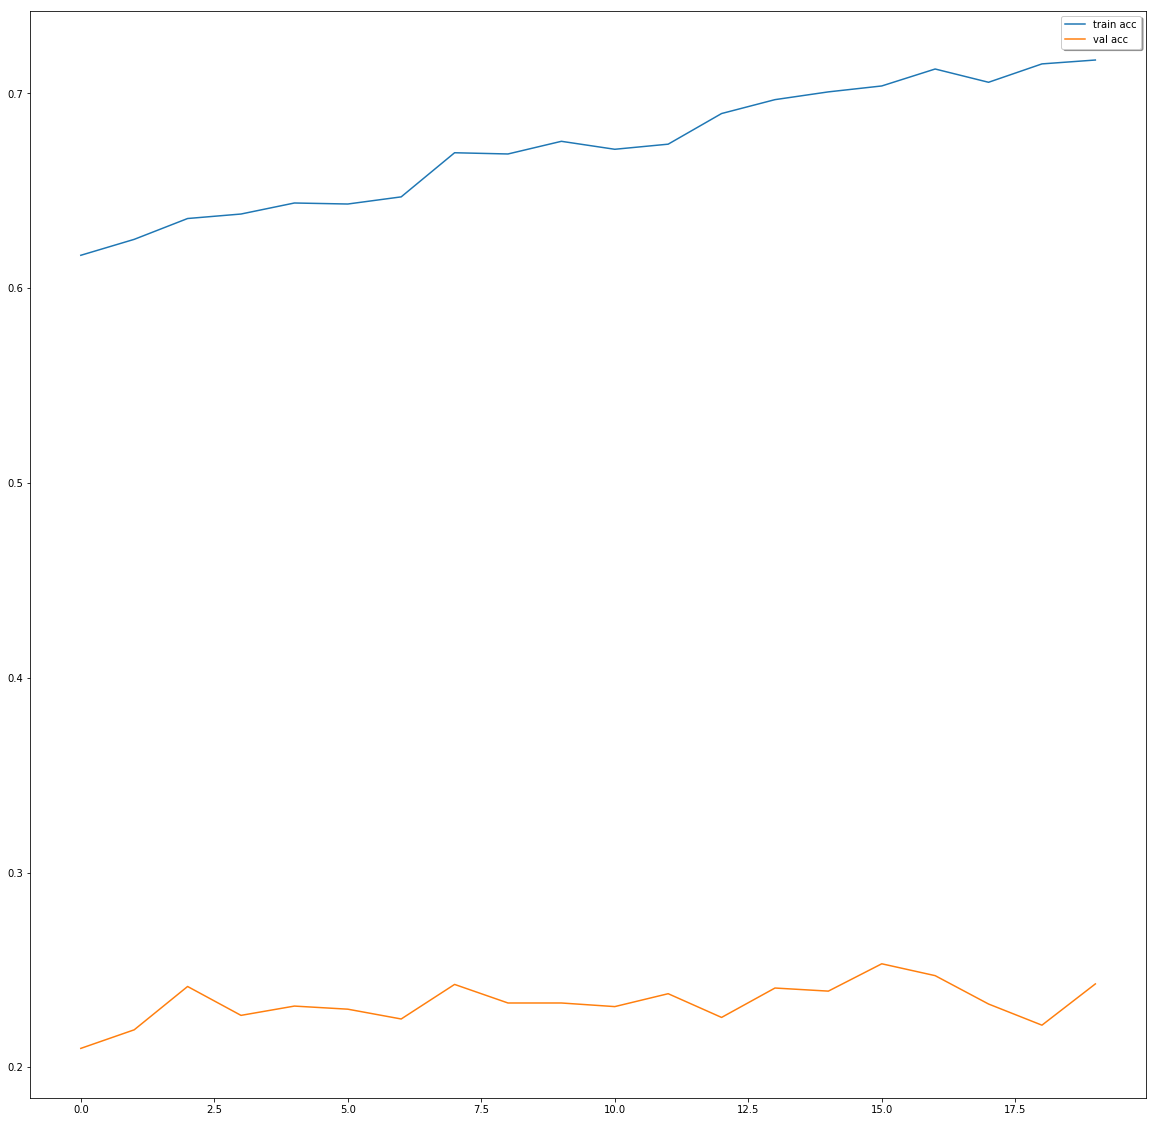

In [15]:

fig, ax = plt.subplots()
ax.plot(mod1.history['acc'], label='train acc')
ax.plot(mod1.history['val_acc'], label='val acc')
legend = ax.legend(loc='best', shadow=True)

You can see that the  train accuracy has far outpaced the validation accuracy which only means one thing.  Over fitting. The next question then is  what is it overfitting (i.e. getting wrong)? The best way to figure this out is probably a confusion matrix.

# Low LR

I'll now decrease  the LR and see if this helps in improving the validation accuracy 

In [17]:
motion_model2=getKerasCifarMotionModel2((224,224,2), 101, dropout=0, printmod=0)

In [18]:
motion_model2.load_weights('/data/su_buildup/two_stream_part2/data/weights/motion_model_weights_inv2_data_aug.hdf5')

In [19]:
mypotim = SGD(lr=1e-4, momentum=0.9)
motion_model2.compile(loss='categorical_crossentropy',
              optimizer=mypotim,
              metrics=['accuracy'])

In [21]:
mod3 = motion_model2.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=4, epochs=5,
                    verbose=1)

Epoch 1/5
298/298 [==============================] - 127s 428ms/step - loss: 1.0888 - acc: 0.7260 - val_loss: 4.0546 - val_acc: 0.2659
Epoch 2/5
298/298 [==============================] - 126s 421ms/step - loss: 1.0439 - acc: 0.7378 - val_loss: 4.1425 - val_acc: 0.2672
Epoch 3/5
298/298 [==============================] - 126s 422ms/step - loss: 1.0250 - acc: 0.7473 - val_loss: 4.1381 - val_acc: 0.2675
Epoch 4/5
298/298 [==============================] - 126s 423ms/step - loss: 0.9895 - acc: 0.7526 - val_loss: 4.1805 - val_acc: 0.2699
Epoch 5/5
298/298 [==============================] - 126s 423ms/step - loss: 1.0004 - acc: 0.7487 - val_loss: 4.2332 - val_acc: 0.2646


In [22]:
mod3 = motion_model2.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=4, epochs=10,
                    verbose=1)

Epoch 1/10
298/298 [==============================] - 126s 422ms/step - loss: 0.9739 - acc: 0.7579 - val_loss: 4.2464 - val_acc: 0.2564
Epoch 2/10
298/298 [==============================] - 126s 421ms/step - loss: 0.9500 - acc: 0.7600 - val_loss: 4.1771 - val_acc: 0.2651
Epoch 3/10
298/298 [==============================] - 126s 422ms/step - loss: 0.9600 - acc: 0.7538 - val_loss: 4.2210 - val_acc: 0.2622
Epoch 4/10
298/298 [==============================] - 126s 422ms/step - loss: 0.9380 - acc: 0.7690 - val_loss: 4.2094 - val_acc: 0.2707
Epoch 5/10
298/298 [==============================] - 126s 424ms/step - loss: 0.9388 - acc: 0.7615 - val_loss: 4.1706 - val_acc: 0.2688
Epoch 6/10
298/298 [==============================] - 126s 423ms/step - loss: 0.9263 - acc: 0.7720 - val_loss: 4.2139 - val_acc: 0.2683
Epoch 7/10
298/298 [==============================] - 126s 423ms/step - loss: 0.9496 - acc: 0.7614 - val_loss: 4.2084 - val_acc: 0.2603
Epoch 8/10
298/298 [============================

In [23]:
motion_model2.save_weights('/data/su_buildup/two_stream_part2/data/weights/motion_model_weights_inv2_data_aug2.hdf5')